In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#### improve版相比之前，在标准变换前补充了一个对数变换
#### 数据范围：2021/08/01-2022/07/31在RG成功付款的用户
#### 数据量：114852

In [2]:
r1=open('RFM_data/RFM_k-means取数_360_1.csv')
r2=open('RFM_data/RFM_k-means取数_360_2.csv')
rfm1=pd.read_csv(r1)
rfm2=pd.read_csv(r2)
rfm=pd.concat((rfm1,rfm2), axis=0)

In [3]:
rfm.head(20)

,user_id,Recency,Frequency,Monetary
0,19542306,42,176,12856.79
1,20489490,4,84,8347.63
2,21839121,54,59,7032.09
3,10402254,1,54,4920.59
4,20172770,2,45,4867.34
5,21966276,7,18,4497.85
6,20583030,3,39,4468.95
7,7808288,101,103,4314.86
8,9439233,3,25,3960.09
9,16729361,22,25,3959.60


In [4]:
#可以看到阈值取分位数和均值的差异程度
rfm.describe() #各字段统计信息

,user_id,Recency,Frequency,Monetary
count,1.148520e+05,114852.000000,114852.000000,114852.000000
mean,1.899346e+07,155.412792,1.407316,107.555560
std,5.009870e+06,107.726013,1.371132,136.393973
min,7.638000e+03,0.000000,1.000000,7.780000
25%,1.826422e+07,62.000000,1.000000,44.480000
50%,2.187334e+07,126.000000,1.000000,71.325000
75%,2.207148e+07,254.000000,1.000000,123.360000
max,2.223546e+07,364.000000,176.000000,12856.790000


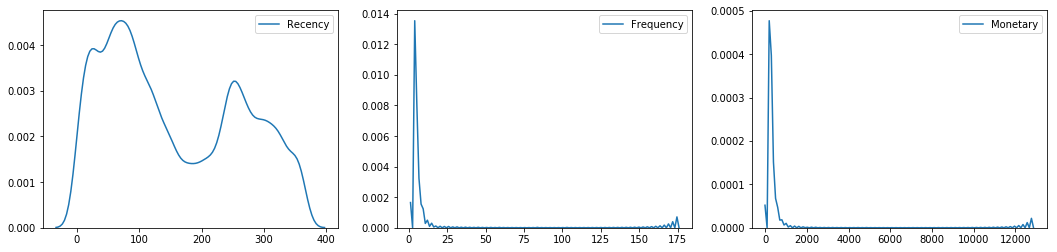

In [5]:
#各变量概率密度分布图
fig, ax=plt.subplots(1,3)
fig.set_size_inches(18,4)
sns.kdeplot(rfm['Recency'], ax=ax[0])
sns.kdeplot(rfm['Frequency'], ax=ax[1])
sns.kdeplot(rfm['Monetary'], ax=ax[2])
# sns.distplot(rfm['Recency'], bins=20, ax=ax[0])
# sns.distplot(rfm['Frequency'], ax=ax[1])
# sns.distplot(rfm['Monetary'], ax=ax[2])

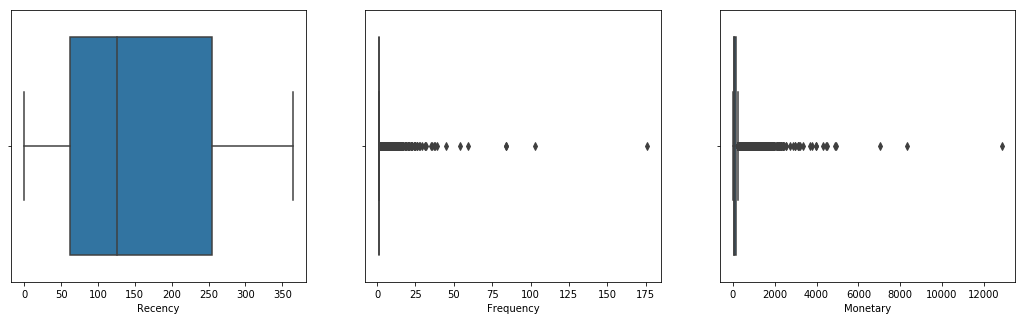

In [6]:
# 各变量箱线图 查看离群点
fig, ax=plt.subplots(1,3)
fig.set_size_inches(18,5)
sns.boxplot(rfm['Recency'], ax=ax[0])
sns.boxplot(rfm['Frequency'], ax=ax[1])
sns.boxplot(rfm['Monetary'], ax=ax[2])

### 实际用到数据量：114829(剔除23个离群点)
#### 完成聚类后，根据各簇的特征，将F>40，M>2500的离群用户放入含有对应特征的簇中。

In [7]:
# drop掉一些离群点
# rfm.drop(index=rfm[rfm['Monetary']>6000].index[0], axis=0, inplace=True)
# rfm.drop(index=rfm[rfm['Frequency']>80].index[0], axis=0, inplace=True)
rfm_drop=rfm[(rfm['Frequency']<=40) & (rfm['Monetary']<=2500)]
# rfm=rfm[rfm['Frequency']<=30]

In [8]:
# 剔除离群点后
rfm_drop.head(20)

,user_id,Recency,Frequency,Monetary
23,7282560,23,16,2445.90
24,21573290,81,12,2418.02
25,22024783,20,23,2399.49
26,19065295,235,2,2393.99
27,21130391,10,19,2379.74
28,21942516,24,10,2354.45
29,21106315,89,7,2311.13
30,21973543,26,25,2309.83
31,21463560,95,21,2297.42
32,21930342,86,13,2255.63


In [9]:
# 剔除离群点后，剩下114829个用户，F和M的方差变小了
#可以看到阈值取分位数和均值的差异程度
rfm_drop.describe() #各字段统计信息

,user_id,Recency,Frequency,Monetary
count,1.148290e+05,114829.000000,114829.000000,114829.000000
mean,1.899372e+07,155.436240,1.399525,106.712778
std,5.009866e+06,107.721261,1.129461,118.412978
min,7.638000e+03,0.000000,1.000000,7.780000
25%,1.826464e+07,62.000000,1.000000,44.470000
50%,2.187358e+07,126.000000,1.000000,71.320000
75%,2.207152e+07,254.000000,1.000000,123.350000
max,2.223546e+07,364.000000,38.000000,2445.900000


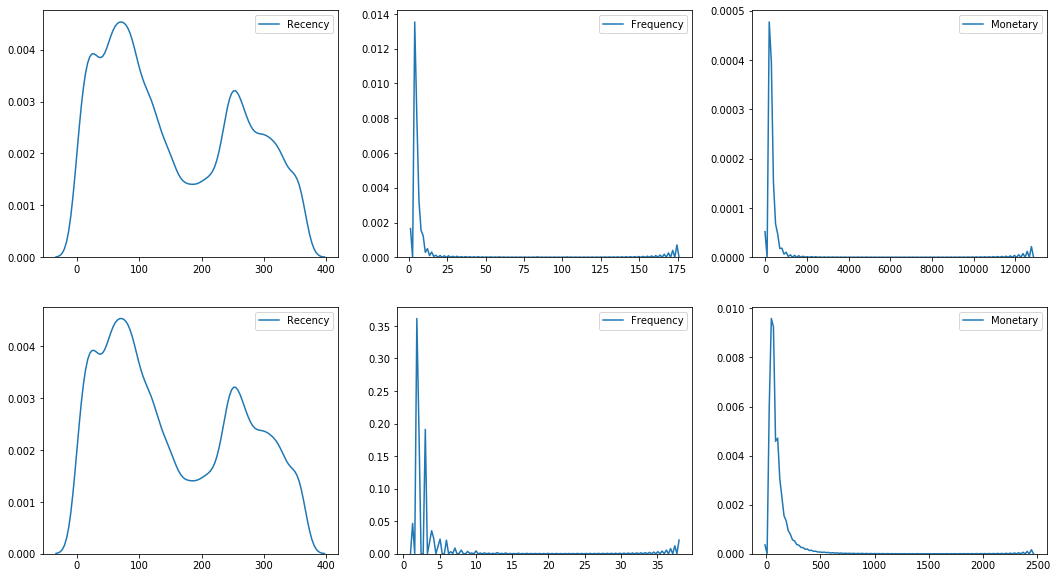

In [10]:
# 删除离群点后
#各变量概率密度分布图
fig, ax=plt.subplots(2,3)
fig.set_size_inches(18,10)
sns.kdeplot(rfm['Recency'], ax=ax[0,0])
sns.kdeplot(rfm['Frequency'], ax=ax[0,1])
sns.kdeplot(rfm['Monetary'], ax=ax[0,2])
sns.kdeplot(rfm_drop['Recency'], ax=ax[1,0])
sns.kdeplot(rfm_drop['Frequency'], ax=ax[1,1])
sns.kdeplot(rfm_drop['Monetary'], ax=ax[1,2])
# sns.distplot(rfm['Recency'], bins=20, ax=ax[0])
# sns.distplot(rfm['Frequency'], ax=ax[1])
# sns.distplot(rfm['Monetary'], ax=ax[2])

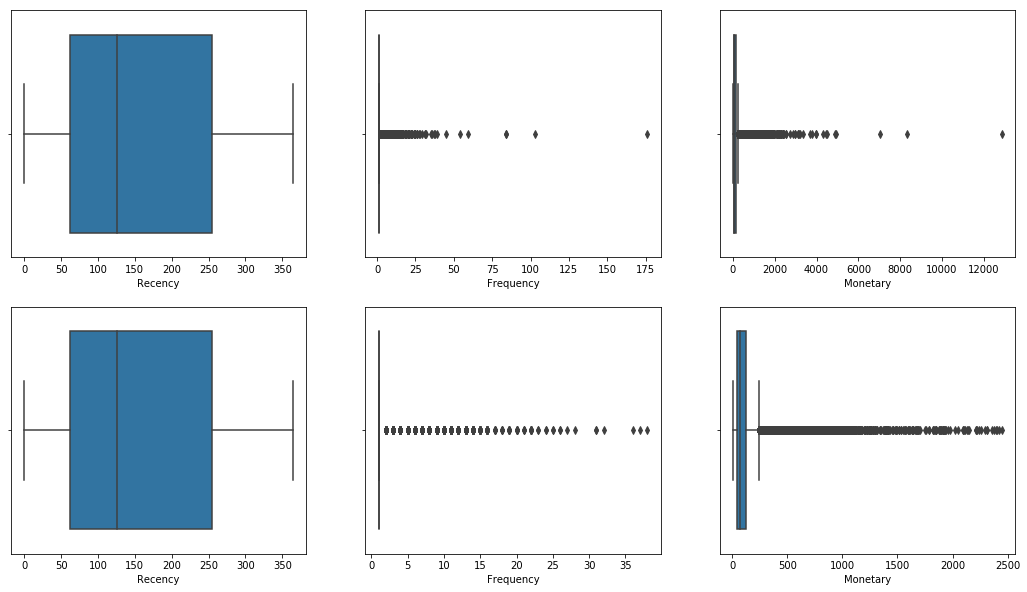

In [11]:
# 剔除离群点后
# 各变量箱线图，F和M的离群点相对没那么明显了
fig, ax=plt.subplots(2,3)
fig.set_size_inches(18,10)
sns.boxplot(rfm['Recency'], ax=ax[0,0])
sns.boxplot(rfm['Frequency'], ax=ax[0,1])
sns.boxplot(rfm['Monetary'], ax=ax[0,2])
sns.boxplot(rfm_drop['Recency'], ax=ax[1,0])
sns.boxplot(rfm_drop['Frequency'], ax=ax[1,1])
sns.boxplot(rfm_drop['Monetary'], ax=ax[1,2])

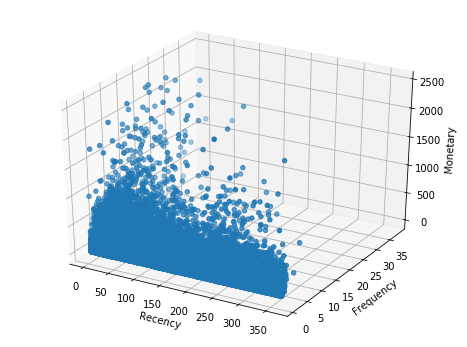

In [12]:
# 初始数据
# %matplotlib notebook  #可旋转，放大缩小。但数据量较大有延迟

# 静态图
%matplotlib inline 

fig=plt.figure()
fig.set_size_inches(8,6)
ax=fig.gca(projection='3d')
ax.scatter(rfm_drop['Recency'],rfm_drop['Frequency'],rfm_drop['Monetary'])
ax.set_xlabel('Recency') # 画出坐标轴
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

In [13]:
# 对数变换前的数据处理，使原始的R、F均大于1
rfm_drop_fix=rfm_drop.copy()
rfm_drop_fix['Recency']=rfm_drop_fix['Recency']+2
rfm_drop_fix['Frequency']=rfm_drop_fix['Frequency']+1

In [14]:
#对数变换
rfm_ln=np.log(rfm_drop_fix[['Recency','Frequency','Monetary']]) 
rfm_ln.head(20)

,Recency,Frequency,Monetary
23,3.218876,2.833213,7.802168
24,4.418841,2.564949,7.790704
25,3.091042,3.178054,7.783011
26,5.468060,1.098612,7.780717
27,2.484907,2.995732,7.774747
28,3.258097,2.397895,7.764062
29,4.510860,2.079442,7.745492
30,3.332205,3.258097,7.744929
31,4.574711,3.091042,7.739542
32,4.477337,2.639057,7.721185


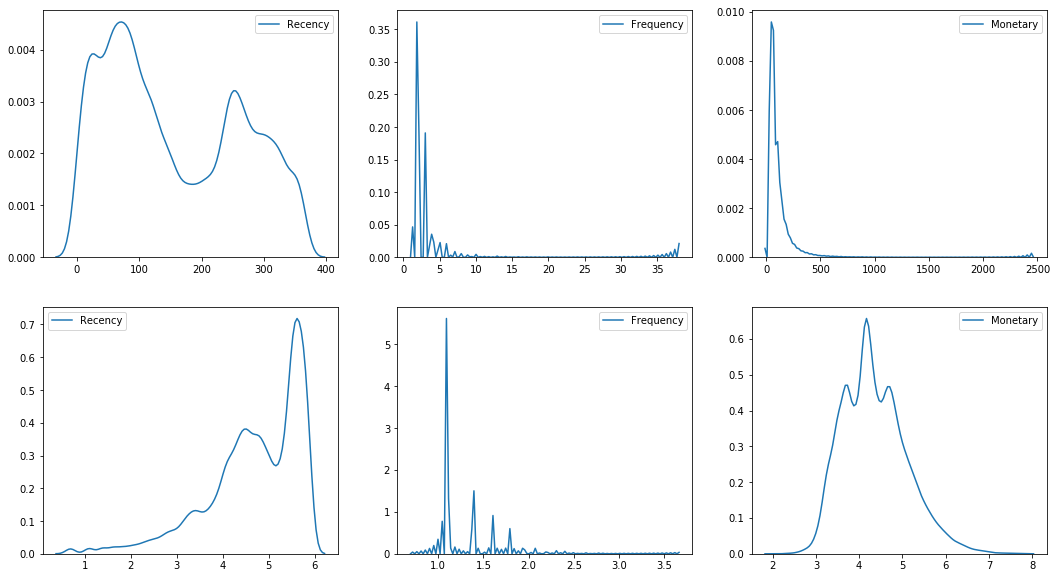

In [15]:
# 对数变换后的rfm直方分布图
fig, ax=plt.subplots(2,3)
fig.set_size_inches(18,10)
sns.kdeplot(rfm_drop['Recency'], ax=ax[0,0])
sns.kdeplot(rfm_drop['Frequency'], ax=ax[0,1])
sns.kdeplot(rfm_drop['Monetary'], ax=ax[0,2])
sns.kdeplot(rfm_ln['Recency'], ax=ax[1,0])
sns.kdeplot(rfm_ln['Frequency'], ax=ax[1,1])
sns.kdeplot(rfm_ln['Monetary'], ax=ax[1,2])

# 对数变换后，仅M近似服从正态分布

In [16]:
# 数据标准化/归一化
# StandardScaler和MinMaxScaler：前者适用于正态分布的数据，后者适用于分布范围较稳定的数据，当新数据的加入导致max/min变化，则需重新定义；前者对outlier些许敏感，后者对outlier非常敏感

scaler=StandardScaler()
rfm_scale=scaler.fit_transform(rfm_ln) #fit找出rfm的均值和标准差，transform将标准化规则运用在rfm上

rfm_scale=pd.DataFrame(rfm_scale, columns=['Recency','Frequency','Monetary'], index=rfm_ln.index)
rfm_scale.head(10)

,Recency,Frequency,Monetary
23,-1.448528,7.133710,4.669308
24,-0.269888,6.182076,4.653773
25,-1.574089,8.356990,4.643348
26,0.760686,0.980423,4.640239
27,-2.169453,7.710227,4.632149
28,-1.410004,5.589472,4.617671
29,-0.179504,4.459796,4.592506
30,-1.337213,8.640932,4.591743
31,-0.116787,8.048328,4.584443
32,-0.212431,6.444965,4.559567


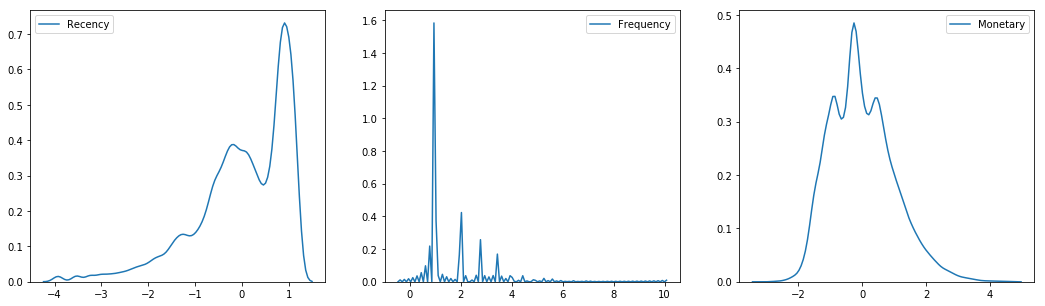

In [19]:
# 标准变换后的rfm_scale直方分布图
fig, ax=plt.subplots(1,3)
fig.set_size_inches(18,5)
sns.kdeplot(rfm_scale['Recency'], ax=ax[0])
sns.kdeplot(rfm_scale['Frequency'], ax=ax[1])
sns.kdeplot(rfm_scale['Monetary'], ax=ax[2])

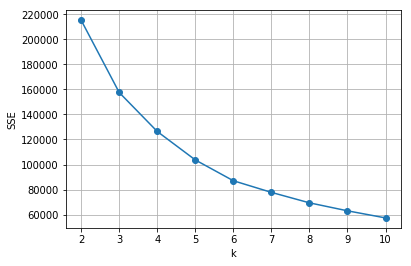

In [20]:
# SSE——样本到簇中心距离的平方和
# k值的选取，确定分为几类
SSE = [] # 存放每次结果的误差平方和
fig=plt.figure()
for k in range(2,11): 
    estimator = KMeans(n_clusters=k, random_state=360) # 构造聚类器 
    estimator.fit(rfm_scale) 
    SSE.append(estimator.inertia_)
X = range(2,11)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.grid()
plt.show()

# 离群点的剔除有助于进一步缩小SSE

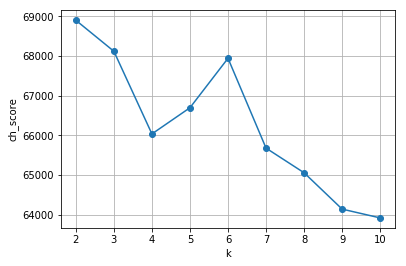

In [21]:
# 哈拉巴斯指数 越大越好，越大代表簇间距离大且簇内距离小
# 哈拉巴斯指数——簇间距离平方和/簇内距离平方和
ch_score = []
x = np.array(rfm_scale[['Recency', 'Frequency', 'Monetary']])
for k in range(2,11):
    model = KMeans(n_clusters = k,max_iter = 1000,random_state=360).fit(x)
    pre = model.predict(x) 
    ch = metrics.calinski_harabaz_score(x,pre)
    ch_score.append(ch)
fig=plt.figure()
plt.xlabel('k')
plt.ylabel('ch_score')
plt.plot(list(range(2,11)),ch_score,'o-')
plt.grid()
plt.show()

# 取k=6

In [52]:
# 轮廓系数法 越大越好 运行内存不够
ss_score = []
x = np.array(rfm_scale[['Recency', 'Frequency', 'Monetary']])
for k in range(2,11):
    model = KMeans(n_clusters = k,max_iter = 100,random_state=360).fit(x)
    pre = model.predict(x) 
    ss = metrics.silhouette_score(x,pre)
    ss_score.append(ss)
fig=plt.figure()
plt.xlabel('k')
plt.ylabel('ss_score')
plt.plot(list(range(2,11)),ss_score,'o-')
plt.grid()
plt.show()

MemoryError: 

## k=6
#### 综合簇内平方和、哈拉巴斯指数得出k=6

In [22]:
kmodel6=KMeans(n_clusters=6, random_state=360) #设置随机种子固定每次聚类的结果
kmodel6.fit(rfm_scale) #训练模型

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=360, tol=0.0001, verbose=0)

In [23]:
# 实际迭代次数
print(kmodel6.n_iter_)

7


In [24]:
# 查看聚类中心
center_360_6=pd.DataFrame(kmodel6.cluster_centers_, columns=['Recency','Frequency','Monetary'])
print(center_360_6)

    Recency  Frequency  Monetary
0 -0.417627  -0.443029 -0.917120
1  0.274198  -0.457916  0.650795
2  0.113461   1.218540  0.925692
3 -0.831433   3.342681  2.151485
4  0.864868  -0.450193 -0.545969
5 -2.071006  -0.095251 -0.062001


In [25]:
#统计各个类别的数目
r2 = pd.Series(kmodel6.labels_).value_counts() 
print(r2)

4    32581
0    25889
1    23568
2    17307
5    10449
3     5035
dtype: int64


In [26]:
# 获取每个样本所属的簇/类别
r3 = pd.DataFrame(kmodel6.labels_, columns=['label'], index=rfm_drop.index)
print(r3)

       label
23         3
24         3
25         3
26         2
27         3
28         3
29         3
30         3
31         3
32         3
33         3
34         3
35         3
36         3
37         3
38         3
39         3
40         3
41         3
42         3
43         3
44         3
45         3
46         3
47         3
48         3
49         3
50         3
51         3
52         3
...      ...
14824      0
14825      0
14826      0
14827      0
14828      0
14829      0
14830      0
14831      0
14832      0
14833      0
14834      0
14835      0
14836      0
14837      0
14838      0
14839      0
14840      0
14841      0
14842      0
14843      0
14844      0
14845      0
14846      0
14847      0
14848      0
14849      0
14850      0
14851      0
14852      0
14853      0

[114829 rows x 1 columns]


In [27]:
# 得到打好标签的用户数据，可输出csv
rfm_label6 = pd.concat([rfm_drop, r3], axis=1)
rfm_label6.head(200)

,user_id,Recency,Frequency,Monetary,label
23,7282560,23,16,2445.90,3
24,21573290,81,12,2418.02,3
25,22024783,20,23,2399.49,3
26,19065295,235,2,2393.99,2
27,21130391,10,19,2379.74,3
28,21942516,24,10,2354.45,3
29,21106315,89,7,2311.13,3
30,21973543,26,25,2309.83,3
31,21463560,95,21,2297.42,3
32,21930342,86,13,2255.63,3


<IPython.core.display.Javascript object>


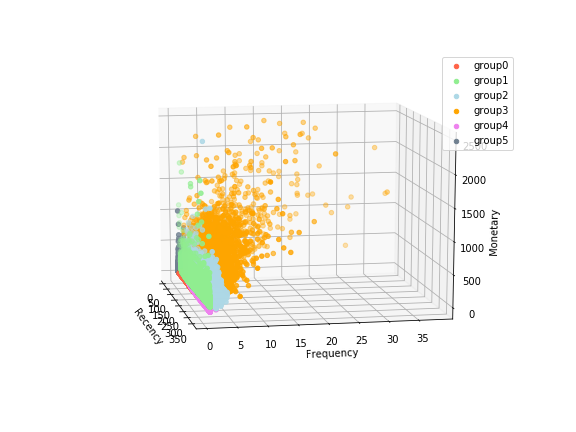

In [29]:
# 原始数据分类可视化
# 群体分层后的三维散点图,可旋转，数据量较大有延迟
%matplotlib notebook

fig=plt.figure()
fig.set_size_inches(8,6)
ax=fig.gca(projection='3d')
color=['tomato','lightgreen','lightblue','orange','violet','slategrey']
for i in range(6):
    d = rfm_label6[rfm_label6.label==i]
    ax.scatter(d['Recency'],d['Frequency'],d['Monetary'],color=color[i],label=f"group{i}")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.legend()

In [30]:
# 标准化后的数据及其分类
rfm_scale_label6 = pd.concat([rfm_scale, r3], axis=1)
rfm_scale_label6.head(20)

,Recency,Frequency,Monetary,label
23,-1.448528,7.133710,4.669308,3
24,-0.269888,6.182076,4.653773,3
25,-1.574089,8.356990,4.643348,3
26,0.760686,0.980423,4.640239,2
27,-2.169453,7.710227,4.632149,3
28,-1.410004,5.589472,4.617671,3
29,-0.179504,4.459796,4.592506,3
30,-1.337213,8.640932,4.591743,3
31,-0.116787,8.048328,4.584443,3
32,-0.212431,6.444965,4.559567,3


<IPython.core.display.Javascript object>


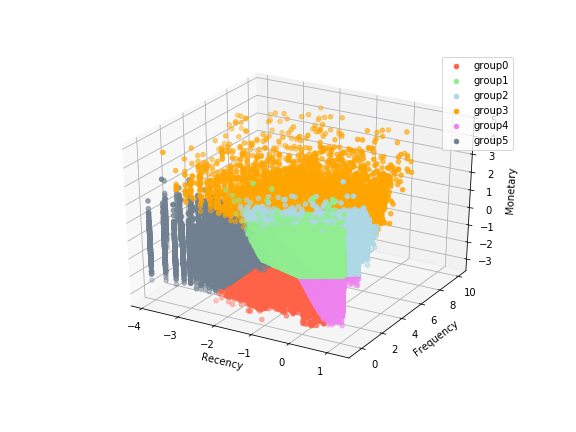

In [31]:
# 标准化数据的分类可视化——更直观且近距离的观测簇与簇的边界
# 对rfm_scale进行可视化0 原始视角
%matplotlib notebook

fig=plt.figure()
fig.set_size_inches(8,6)
ax=fig.gca(projection='3d')
color=['tomato','lightgreen','lightblue','orange','violet','slategrey']
for i in range(6):
    d = rfm_scale_label6[rfm_scale_label6.label==i]
    ax.scatter(d['Recency'],d['Frequency'],d['Monetary'],color=color[i],label=f"group{i}")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.legend()

<IPython.core.display.Javascript object>


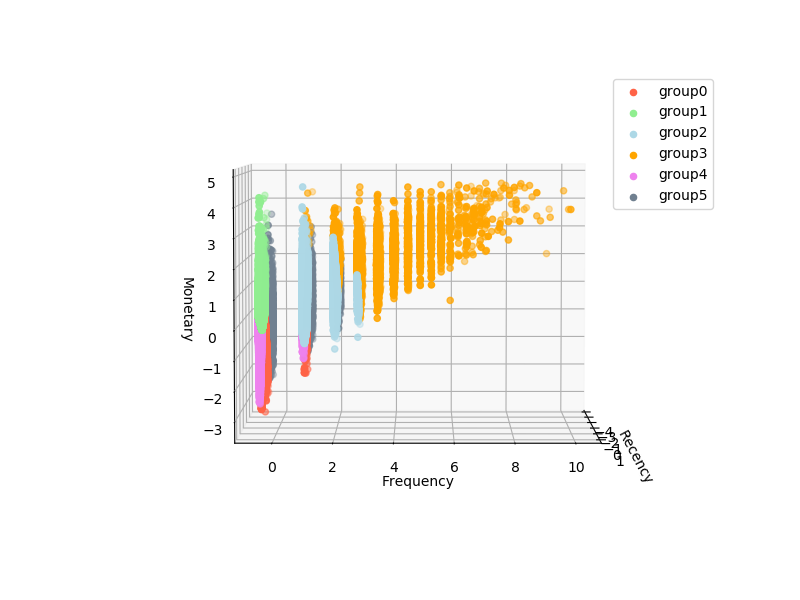

In [53]:
# 对rfm_scale进行可视化1 二维视角之Frequency&Monetary
%matplotlib notebook

fig=plt.figure()
fig.set_size_inches(8,6)
ax=fig.gca(projection='3d')
color=['tomato','lightgreen','lightblue','orange','violet','slategrey']
for i in range(6):
    d = rfm_scale_label6[rfm_scale_label6.label==i]
    ax.scatter(d['Recency'],d['Frequency'],d['Monetary'],color=color[i],label=f"group{i}")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.legend()

<IPython.core.display.Javascript object>


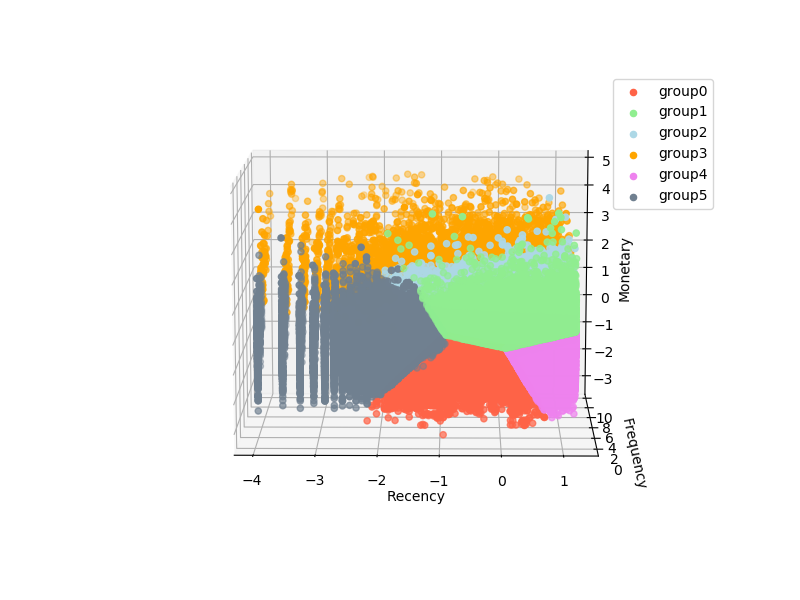

In [54]:
# 对rfm_scale进行可视化2 二维视角之Recency&Monetary
%matplotlib notebook

fig=plt.figure()
fig.set_size_inches(8,6)
ax=fig.gca(projection='3d')
color=['tomato','lightgreen','lightblue','orange','violet','slategrey']
for i in range(6):
    d = rfm_scale_label6[rfm_scale_label6.label==i]
    ax.scatter(d['Recency'],d['Frequency'],d['Monetary'],color=color[i],label=f"group{i}")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.legend()

<IPython.core.display.Javascript object>


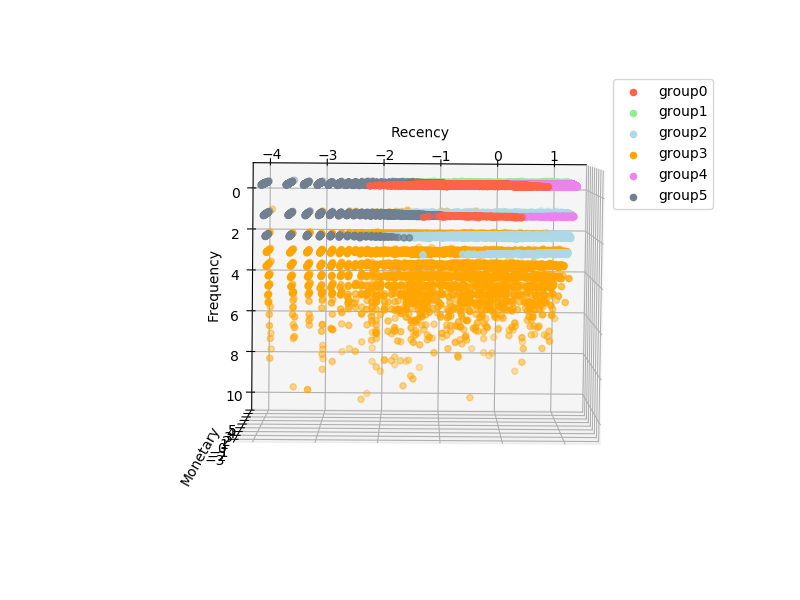

In [55]:
# 对rfm_scale进行可视化3 二维视角之Recency&Frequency
%matplotlib notebook

fig=plt.figure()
fig.set_size_inches(8,6)
ax=fig.gca(projection='3d')
color=['tomato','lightgreen','lightblue','orange','violet','slategrey']
for i in range(6):
    d = rfm_scale_label6[rfm_scale_label6.label==i]
    ax.scatter(d['Recency'],d['Frequency'],d['Monetary'],color=color[i],label=f"group{i}")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.legend()

### 聚类中心点还原_含对数变换和R+2 F+1

In [32]:
ms360=rfm_ln.describe().iloc[1:3,]
ms360

,Recency,Frequency,Monetary
mean,4.693611,0.822233,4.356407
std,1.018097,0.281899,0.737963


In [33]:
center_360_6

,Recency,Frequency,Monetary
0,-0.417627,-0.443029,-0.917120
1,0.274198,-0.457916,0.650795
2,0.113461,1.218540,0.925692
3,-0.831433,3.342681,2.151485
4,0.864868,-0.450193,-0.545969
5,-2.071006,-0.095251,-0.062001


In [34]:
a=pd.DataFrame()

for i in range(3):
    a[i]=center_360_6.iloc[:,i].values*ms360.iloc[1,i]+ms360.iloc[0,i]
    a[i]=np.exp(a[i])

center_360_6_reverse=pd.DataFrame(a, index=center_360_6.index)
center_360_6_reverse.columns=['R','F','M']

center_360_6_reverse['R']=center_360_6_reverse['R']-2
center_360_6_reverse['F']=center_360_6_reverse['F']-1

center_360_6_reverse

,R,F,M
0,69.409166,1.008410,39.630764
1,142.426602,0.999999,126.048855
2,120.624328,2.208292,154.397904
3,44.858462,4.838844,381.504742
4,261.520495,1.004358,52.117538
5,11.264960,1.215286,74.489023


In [35]:
kmodel6.lablecount=pd.DataFrame(pd.Series(kmodel6.labels_).value_counts() , columns=['count'])
kmodel6.lablecount

,count
4,32581
0,25889
1,23568
2,17307
5,10449
3,5035


In [36]:
# 各簇中心点、数量
center_360_6_count=pd.concat((center_360_6_reverse,kmodel6.lablecount), axis=1)
center_360_6_count.sort_values(by='count', inplace=True)
center_360_6_count=center_360_6_count.round({'R':2,'F':2,'M':2})
center_360_6_count

,R,F,M,count
3,44.86,4.84,381.50,5035
5,11.26,1.22,74.49,10449
2,120.62,2.21,154.40,17307
1,142.43,1.00,126.05,23568
0,69.41,1.01,39.63,25889
4,261.52,1.00,52.12,32581


C:\Users\Administrator.sf-202111191756\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Administrator.sf-202111191756\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Administrator.sf-202111191756\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Administrator.sf-202111191756\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users

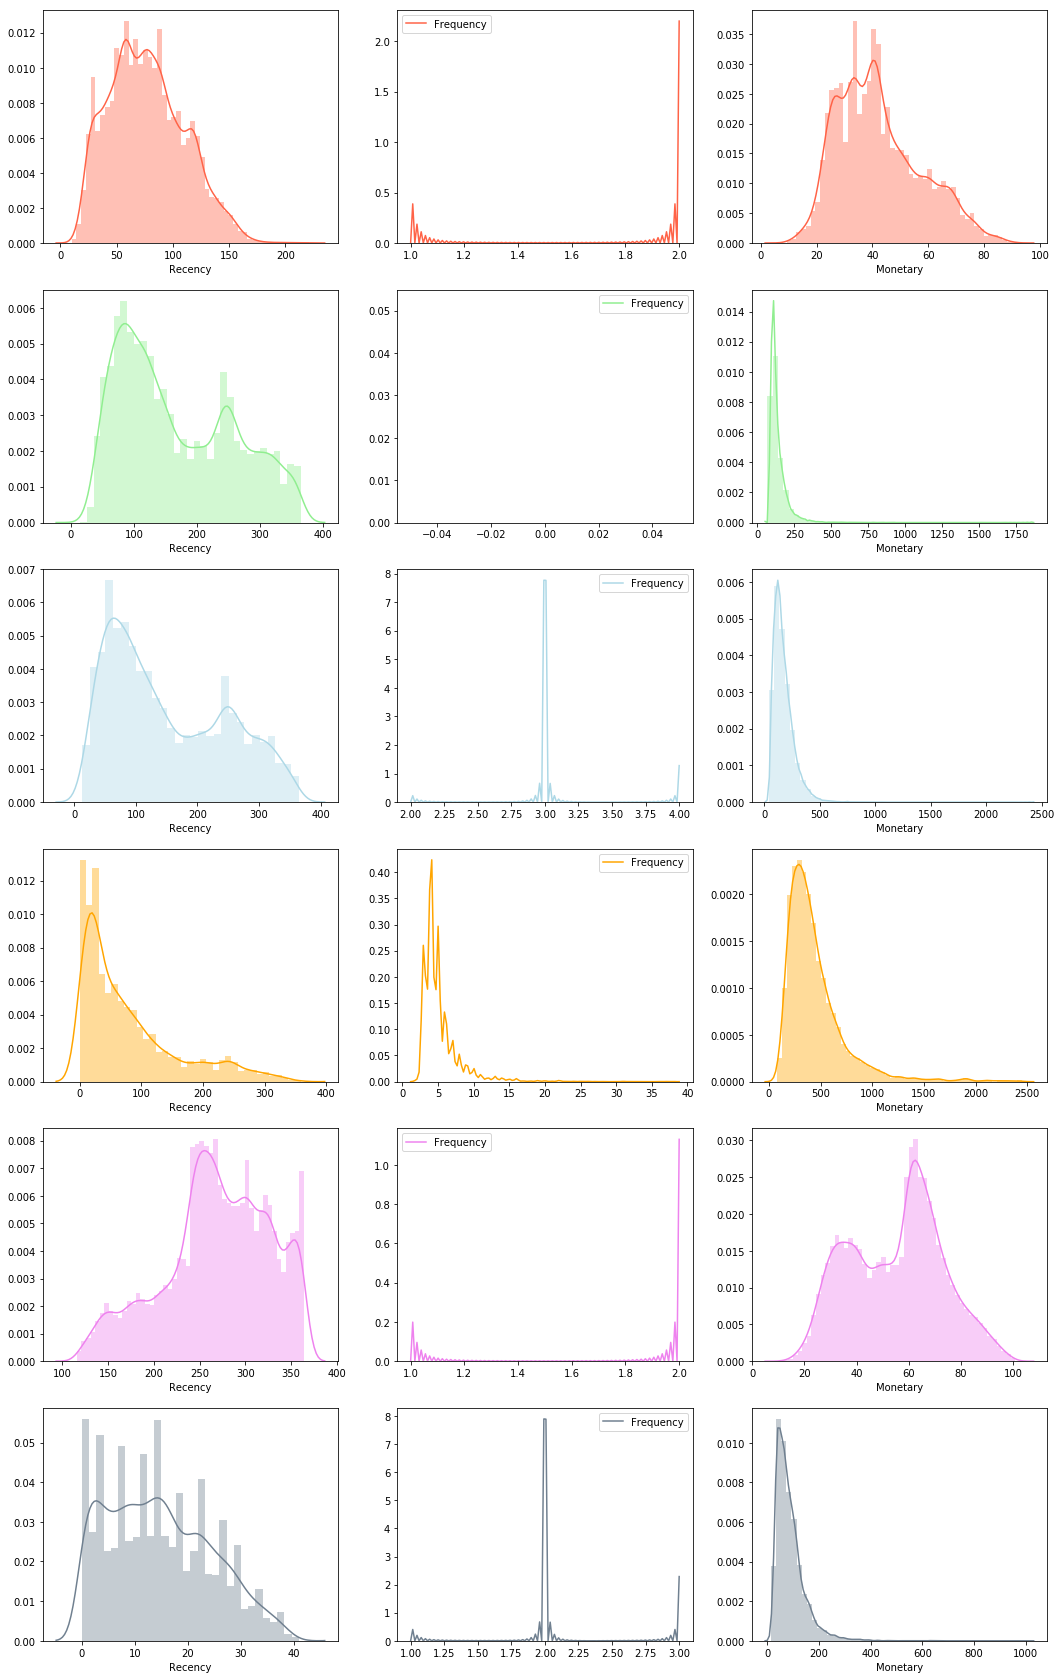

In [37]:
# 原始数据 各簇RFM的分布对比

# 各图的坐标单位不一致

# 静态图
%matplotlib inline 

fig, ax=plt.subplots(6,3)
fig.set_size_inches(18,30)

color=['tomato','lightgreen','lightblue','orange','violet','slategrey']
for i in range(6):
    d = rfm_label6[rfm_label6.label==i]
    sns.distplot(d['Recency'], color=color[i], ax=ax[i,0])
    sns.kdeplot(d['Frequency'], color=color[i], ax=ax[i,1])
    sns.distplot(d['Monetary'], color=color[i], ax=ax[i,2])

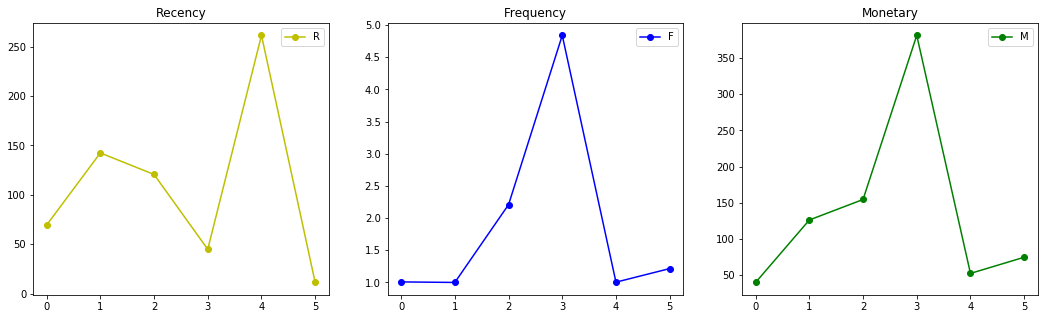

In [38]:
# 各簇中心点折线对比图
# 横轴代表第几簇，如：第三簇中心点的F和M最大
fig = plt.figure(figsize=(18,5))
ax1= fig.add_subplot(131)
ax1.plot(list(range(6)),center_360_6_reverse.R,c='y',label='R',marker='o')
plt.title('Recency')
plt.legend()
ax2= fig.add_subplot(132)
ax2.plot(list(range(6)),center_360_6_reverse.F,c='b',label='F',marker='o')
plt.title('Frequency')
plt.legend()
ax3= fig.add_subplot(133)
ax3.plot(list(range(6)),center_360_6_reverse.M,c='g',label='M',marker='o')
plt.title('Monetary')
plt.legend()
plt.show()

In [39]:
# 输出各簇中心点、数量
center_360_6_count.to_csv('RFM_data/center_360_6_count')

In [40]:
# 输出原始数据及其分类结果
rfm_label6.to_csv('RFM_data/rfm_label6')